In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels


In [3]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 9999:
Image - Min Value: 3 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


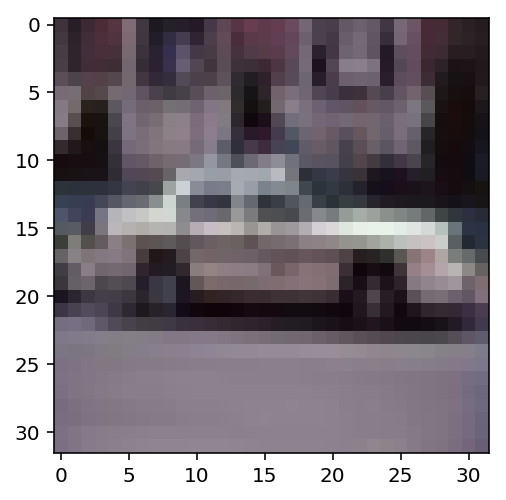

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 9999
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [5]:
features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[0]

In [6]:
learning_rate = 0.001
training_iters =  300
batch_size = 64
display_step = 100

In [7]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

## placeholder variables

In [60]:
import tensorflow as tf
a = tf.placeholder(tf.float32, (200,32,32,1))
x_image = tf.reshape(a,[-1,32,32,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
keep_prob = tf.placeholder(tf.float32)
session.run(tf.global_variables_initializer())


In [30]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [31]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [32]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    #layerConvOut = layer

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    #layer += biases

    return layer, weights, biases

In [33]:
def pooling_relu(input,              # The previous layer.
                  use_pooling=True):  # Use 2x2 max-pooling.


    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=input,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer

In [34]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

## helper function for a fully connected layer

In [35]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

In [36]:
num_channels = 1
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

# convolution layer1
filter_size1 = 3
num_filters1 = 64

# convolution layer2
filter_size2 = 3
num_filters2 = 128

#convolution layer3
filter_size3 = 3
num_filters3 = 256


fc_size1 = 1024
fc_size2 = 1024
fc_size3 = 10

In [37]:
def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

In [38]:
layer_conv1, weights_conv1,biases_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

layer_conv1_biases = layer_conv1 + biases_conv1
pool1 = max_pool('pool1', layer_conv1_biases, k=2)
norm1 = norm('norm1', pool1, lsize=4)
_dropout = keep_prob
norm1 = tf.nn.dropout(norm1, _dropout)
layer_conv2, weights_conv2,biases_conv2 = \
    new_conv_layer(input=norm1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

layer_conv2_biases = layer_conv2 + biases_conv2
pool2 = max_pool('pool2', layer_conv2_biases, k=2)
    # Apply Normalization
norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
norm2 = tf.nn.dropout(norm2, _dropout)

layer_conv3, weights_conv3,biases_conv3 = \
    new_conv_layer(input=norm2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3)

layer_conv3_biases = layer_conv3 + biases_conv3

pool3 = max_pool('pool3', layer_conv3, k=2)
    # Apply Normalization
norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
norm3 = tf.nn.dropout(norm3, _dropout)
layer_flat, num_features = flatten_layer(norm3)


In [39]:
layer_fc1,weights_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)
layer_flat1, num_features1 = flatten_layer(layer_fc1)
layer_fc2,weights_fc2 = new_fc_layer(input=layer_flat1,
                         num_inputs=num_features1,
                         num_outputs=fc_size2,
                         use_relu=True)
layer_flat2, num_features2 = flatten_layer(layer_fc2)
layer_fc3,weights_fc3 = new_fc_layer(input=layer_flat2,
                         num_inputs=num_features2,
                         num_outputs=fc_size3,
                         use_relu=True)
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [40]:
session.run(tf.global_variables_initializer())

In [41]:
train_batch_size = 64


## store the original weights

In [42]:
w_conv1_original = session.run(weights_conv1)
w_conv2_original = session.run(weights_conv2)
w_conv3_original = session.run(weights_conv3)

w_fc1_original = session.run(weights_fc1)
w_fc2_original = session.run(weights_fc2)
w_fc3_original = session.run(weights_fc3)
wOrigConv = [w_conv1_original,w_conv2_original, w_conv3_original]
wOrigFc = [w_fc1_original, w_fc2_original, w_fc3_original]


## restore weights

In [43]:
def restoreWeights():
    for wIdx in range(0,len(weightsConvMat)):
            assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
            session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
            assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
            session.run(assign_op)

In [45]:
#restoreWeights()

In [46]:
weightsConvMat = [weights_conv1,weights_conv2, weights_conv3]
weightsFcMat = [weights_fc1, weights_fc2, weights_fc3]

wConv1 = session.run(weights_conv1)
wConv2 = session.run(weights_conv2)
wConv3 = session.run(weights_conv3)
wFc1 = session.run(weights_fc1)
wFc2 = session.run(weights_fc2)
wFc3 = session.run(weights_fc3)
wConv = [wConv1,wConv2, wConv3]
wFc = [wFc1,wFc2, wFc3]

## container to hold the difference

In [47]:
wDiffConv = [] + wOrigConv
wDiffFc = [] + wOrigFc

In [48]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2

In [49]:
centroidFilter(wConv, wFc)

## assign filters

In [50]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [51]:
assignFilters(wConv,wFc)

In [52]:
def loadValues(numImg):
    
    feed_dict = {a: imageTest, keep_prob:dropout}
    values_conv1 = session.run(layer_conv1, feed_dict=feed_dict)
    
    values_conv2 = session.run(layer_conv2, feed_dict=feed_dict)
    values_conv3 = session.run(layer_conv3, feed_dict = feed_dict)
    values_fc1 = session.run(layer_fc1, feed_dict = feed_dict)
    values_fc2 = session.run(layer_fc2, feed_dict = feed_dict)
    values_fc3 = session.run(layer_fc3, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesFcMat = [values_fc1, values_fc2, values_fc3]
    
    return valuesConvMat, valuesFcMat, numImg

In [53]:
imageTest = features[0:200]



In [54]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
   ## print("we are in the calculateConvME function")
   ## print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters are")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [55]:
def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [56]:
def plotMEConvolution(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

In [57]:
def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

In [58]:
loadValues(100)

ValueError: Cannot feed value of shape (200, 32, 32, 3) for Tensor 'Placeholder_3:0', which has shape '(100, 28, 28, 1)'